In [386]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.sparse import rand as sprand
import torch
import numpy as np
from torch.autograd import Variable

In [387]:
#@save
def read_data_ml100k():

    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv('u.data', '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [388]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


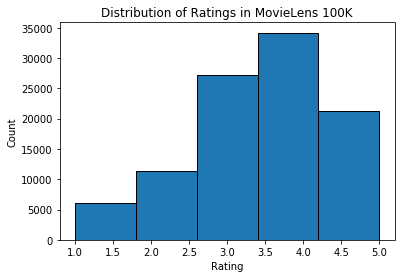

In [389]:

plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

In [390]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [391]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [407]:
def read_original_data(filename: str):
    train_dict = dict()
    test_dict = dict()
    train_list = []
    test_list = []
    max_user_id, min_user_id, max_item_id, min_item_id = [10] * 4

    with open(filename, "r", encoding="utf-8") as txt_file:
        for idx, line in enumerate(txt_file):
            # if idx > 50:
            #     break
            user_id, item_id, rating, times = line.strip().split('\t')
            user_id = int(user_id)
            item_id = int(item_id)
            rating = int(rating)

            if user_id > max_user_id:
                max_user_id = user_id
            elif user_id < min_user_id:
                min_user_id = user_id

            if item_id > max_item_id:
                max_item_id = item_id
            elif item_id < min_item_id:
                min_item_id = item_id

            train_dict.setdefault(user_id, []).append((item_id, rating))
            if user_id not in test_dict or times > test_dict[user_id][-1]:
                test_dict[user_id] = (item_id, rating, times)

    for user_id in train_dict:
        for info in train_dict[user_id]:
            item_id = info[0]
            if item_id != test_dict[user_id][0]:
                train_list.append((user_id, item_id, info[1]))
            else:
                test_list.append((user_id, item_id, info[1]))
    return train_list, test_list, [min_user_id, max_user_id], [min_item_id, max_item_id]


def generate_matrix(n_items: int, n_users: int, data: list):
    result = [[0] * n_users] * n_items
    for element in data:
        user_id, item_id, rating = element
        result[item_id - 1][user_id - 1] = rating
    return result


def write_format(target_list: list):
    return "\t".join([str(i) for i in target_list]) + "\n"


def evaluate(test_info: list, predict_matrix: list, filename: str):
    mse = 0
    with open(filename, "w", encoding="utf-8") as txt_file:
        for element in test_info:
            user_id, item_id, rating = element
            predict_value = predict_matrix[item_id - 1][user_id - 1]
            mse += (predict_value - rating) ** 2
            txt_file.write(write_format(target_list=[user_id, item_id, rating, predict_value]))

    mse /= len(test_data)
    mse = np.sqrt(mse)
    print(mse)

# Matrix Factorization

R interaction matrix \n
P: measure the extent of interest the use has in items' corresponding characteristics' \n
R_ui = p_u q_i + b_u + b_i \n
train using l2 loss + ridge regression penality \n
matrix evaluation is RMSE loss \n


In [432]:
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, 
                                               n_factors
                                               )
        self.item_factors = torch.nn.Embedding(n_items, 
                                               n_factors
                                               
                                               )
        self.user_bias = torch.nn.Embedding(n_users, 1)
        self.item_bias = torch.nn.Embedding(n_items, 1)
        torch.nn.init.normal_(self.user_factors.weight, 0.1)
        torch.nn.init.normal_(self.item_factors.weight, 0.1)
        self.user_bias.weight.data.fill_(0.)
        self.item_bias.weight.data.fill_(0.)
        
    def forward(self, user, item): #squeeze remove dimension equals to 1
        #print((self.user_factors(user) * self.item_factors(item)).sum(1).shape)
        #print(self.user_bias(user).shape)
        return torch.nn.functional.relu((self.user_factors(user) * self.item_factors(item)).sum(1) + self.user_bias(user).squeeze() + self.item_bias(item).squeeze())
    

In [433]:
#generate data
num_users, num_items = 943, 1682
train, test = split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.2)

In [434]:
#evaluation method
def evaluator(model, test):
    rating = torch.FloatTensor([test['rating'].values]).squeeze()
    row = torch.LongTensor([test['user_id'].values]).squeeze()
    col = torch.LongTensor([test['item_id'].values]).squeeze()
    return torch.sqrt(((model(row, col) - rating)**2).sum()/len(rating))
    
    

In [ ]:
#training and testing
n_users, n_items = 944, 1683
loss_func = torch.nn.MSELoss()
model = MatrixFactorization(n_users, n_items, n_factors=10)
optimizer = torch.optim.Adam(model.parameters(), 
                            lr= 1e-4, weight_decay = 1e-4 ) # learning rate

l = np.array(list(range(79973)))

for i in range(400):
    random.shuffle(l)
    loss_sum = 0
    for ind in range(0, 79973, 512):
            # Turn data into tensors
            rating = Variable(torch.FloatTensor([train['rating'].iloc[l[ind: ind + 512]].values]).squeeze())
            row = Variable(torch.LongTensor([train['user_id'].iloc[l[ind: ind + 512]].values]).squeeze())
            col = Variable(torch.LongTensor([train['item_id'].iloc[l[ind: ind + 512]].values]).squeeze())

            # Predict and calculate loss
            prediction = model(row, col)
            loss = loss_func(prediction, rating)

            # Backpropagate
            loss.backward()
            loss_sum += loss
            # Update the parameters
            optimizer.step()
    print(evaluator(model, test), loss_sum, evaluator(model, train))

tensor(3.1235, grad_fn=<SqrtBackward>) tensor(1557.1904, grad_fn=<AddBackward0>) tensor(3.1311, grad_fn=<SqrtBackward>)
tensor(3.1038, grad_fn=<SqrtBackward>) tensor(1526.6769, grad_fn=<AddBackward0>) tensor(3.0955, grad_fn=<SqrtBackward>)
tensor(3.0839, grad_fn=<SqrtBackward>) tensor(1489.7649, grad_fn=<AddBackward0>) tensor(3.0595, grad_fn=<SqrtBackward>)
tensor(3.0638, grad_fn=<SqrtBackward>) tensor(1455.4121, grad_fn=<AddBackward0>) tensor(3.0242, grad_fn=<SqrtBackward>)
tensor(3.0437, grad_fn=<SqrtBackward>) tensor(1420.6229, grad_fn=<AddBackward0>) tensor(2.9896, grad_fn=<SqrtBackward>)
tensor(3.0234, grad_fn=<SqrtBackward>) tensor(1388.5786, grad_fn=<AddBackward0>) tensor(2.9557, grad_fn=<SqrtBackward>)
tensor(3.0028, grad_fn=<SqrtBackward>) tensor(1356.2891, grad_fn=<AddBackward0>) tensor(2.9225, grad_fn=<SqrtBackward>)


1. plotting using plotly
2. try different optimizer and see the result
3. wanshan review optimizer after work
4. Why use variable

take away
initialization is very important
train on sparse stuff is very slow

# AutoRec

def: identify CF with an autoencoder architecture and aims to integrate nonlinear transformations into 
    CF on the basis of explicit feedback
structure: an input layer, a hidden layer, and a reconstruction layer. 
    use column/row of the interaction matrix as an input
    

In [397]:
class AutoRec(torch.nn.Module):
    
    def __init__(self, n_users,  n_factors=20, dropout = 0.05):
        super().__init__()
        self.encoder = torch.nn.Linear(n_users, n_factors,  bias=True)
        self.act = torch.nn.Sigmoid()
        self.decoder = torch.nn.Linear(n_factors, n_users, bias=True)
        self.dropout = torch.nn.Dropout(dropout)
        #self.relu = torch.nn.ReLU(inplace=False)
        torch.nn.init.normal_(self.encoder.weight, 0.01)
        torch.nn.init.normal_(self.decoder.weight, 0.01)
        #torch.nn.init.normal_(self.act.weight, 0.01)
        
    def forward(self, user, is_train=1 ): #squeeze remove dimension equals to 1
        hidden = self.dropout(self.act(self.encoder(user)))
        #print(hidden)
        pred = self.decoder(hidden)
#         if autograd.is_training():  # Mask the gradient during training
#             return pred * np.sign(input) 
#         else:
#             
        if is_train == 1:
            pred = pred * np.sign(user)
        return pred

In [398]:
n_users = 943


In [399]:
train_trans = train.pivot_table(index='item_id', columns='user_id').loc[:, 'rating']
train_trans = train_trans.reset_index().drop('item_id', axis = 1).fillna(0)

AttributeError: 'list' object has no attribute 'pivot_table'

In [400]:
test_trans = test.pivot_table(index='item_id', columns='user_id').loc[:, 'rating']
test_trans = test_trans.reset_index().drop('item_id', axis = 1).fillna(0)
for i in range(1, 944):
    if i not in test_trans.columns:
        test_trans[i] = 0
test_trans = test_trans.sort_index(ascending=True, axis=1)

AttributeError: 'list' object has no attribute 'pivot_table'

In [401]:
def evaluate_matrix(test_trans):
    val = (model(Variable(torch.FloatTensor(test_trans.values))).detach().numpy() - test_trans.values)**2
    #print(val)
    sign = np.sign(test_trans.values)

    return np.sqrt(np.sum(val * sign)/np.sum(sign))

关于 loss

loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. In pseudo-code:

x.grad += dloss/dx
optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:

x += -lr * x.grad
optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:

loss3 = loss1 + loss2
loss3.backward()

tensor([-1.4953,  1.5546,  1.4921,  0.4234])

对于 istraining 比 在拿到pred 用sign 更快

In [404]:
n_users, n_items = 943, 1683
loss_func = torch.nn.MSELoss()
model = AutoRec(n_users, n_factors=100)
optimizer = torch.optim.Adam(model.parameters(), 
                            lr= 0.002, weight_decay = 1e-5 ) # learning rate

l = np.array(list(range(943)))

test, train = [], []
for i in range(1000):
    random.shuffle(l)
    loss_sum = 0
    model.train()
    for ind in range(0, 943, 256):
            # Turn data into tensors
            rating = Variable(torch.FloatTensor([train_trans.iloc[l[ind: ind + 256]].values]))
            
            # Predict and calculate loss
            prediction = model(rating)
            #method1: register and match
            #prediction.register_hook(lambda grad: grad * torch.FloatTensor(np.sign(train_trans.iloc[l[ind: ind + 256]].values) ))
            
            #method 1 mask after model
            sign = torch.FloatTensor(np.sign(train_trans.iloc[l[ind: ind + 256]].values))
            loss = loss_func(prediction * sign, rating * sign)

            #mask in the model
            loss = loss_func(prediction , rating )
            
                
            # Backpropagate
            loss.backward()
            loss_sum += loss
            # Update the parameters
            optimizer.step()
    if i % 10 == 0:
        model.eval()
        test.append(evaluate_matrix(test_trans))
        train.append(evaluate_matrix(train_trans))
        print(evaluate_matrix(test_trans), loss_sum, evaluate_matrix(train_trans))

14.683326210634394 tensor(88.4654, grad_fn=<AddBackward0>) 14.797309719910269
12.475249047027127 tensor(42.4289, grad_fn=<AddBackward0>) 11.199343685069225
12.276483609264808 tensor(33.4972, grad_fn=<AddBackward0>) 9.896485949835231
11.022524319563313 tensor(26.4467, grad_fn=<AddBackward0>) 8.9694888470072
9.484044306429725 tensor(21.3801, grad_fn=<AddBackward0>) 7.95752944927133
7.964184591698304 tensor(15.8457, grad_fn=<AddBackward0>) 6.886913289981216
6.843455180860399 tensor(11.9608, grad_fn=<AddBackward0>) 5.950099806256724
5.90475264609777 tensor(8.2655, grad_fn=<AddBackward0>) 4.985017883117118
5.147927477276663 tensor(6.0361, grad_fn=<AddBackward0>) 4.294854373047684
4.546448059622635 tensor(4.8081, grad_fn=<AddBackward0>) 3.8006649904748198
4.0556940215884945 tensor(3.7723, grad_fn=<AddBackward0>) 3.3880557759090526
3.641942445492659 tensor(3.1096, grad_fn=<AddBackward0>) 3.0642911719193533
3.3031199671144416 tensor(2.5150, grad_fn=<AddBackward0>) 2.7761436186668624
3.01896093

In [406]:
test

[14.683326210634394,
 12.475249047027127,
 12.276483609264808,
 11.022524319563313,
 9.484044306429725,
 7.964184591698304,
 6.843455180860399,
 5.90475264609777,
 5.147927477276663,
 4.546448059622635,
 4.0556940215884945,
 3.641942445492659,
 3.3031199671144416,
 3.0189609395938124,
 2.771066959438655,
 2.572145617036963,
 2.410551102895394,
 2.2946238418713523,
 2.215802969735319,
 2.167462342895875,
 2.1404472969946964,
 2.153221126055412,
 2.1789268210186488,
 2.197816799358841,
 2.198970288729983,
 2.1757496533662484,
 2.138508610381834,
 2.0800196376314926,
 2.014752802526856,
 1.9511535692784492,
 1.9097884645532845,
 1.8906548364456066,
 1.8913786402755999,
 1.9066041910334697,
 1.9360208972722108,
 1.957463781849139,
 1.9755081534670722,
 1.9915148640174878,
 1.9989166400298568,
 1.9954819987442622,
 1.9746757615552641,
 1.9433508421546886,
 1.9120038646850395,
 1.883795021583302,
 1.862630234090203,
 1.8450689888643566,
 1.838153891284403,
 1.8432227333827234,
 1.86050720039

In [272]:
!pip install plotly==4.9.0

    100% |████████████████████████████████| 12.9MB 3.3MB/s eta 0:00:01
  Running setup.py bdist_wheel for retrying ... done
  Stored in directory: /Users/two/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
You are using pip version 18.0, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [300]:
test

[5.936595359627366,
 4.308426273341203,
 3.400383175321424,
 2.895760221532256,
 2.556590823070144,
 2.3519294807880846,
 2.1920607502285985,
 2.066014936505195,
 1.999229770205389,
 1.9863220345946528,
 2.001368078433109,
 2.0221929218828563,
 2.0450972254915074,
 2.061240292249084,
 2.0547907136820602,
 2.017839706163737,
 1.9668001342790007,
 1.9042236409901392,
 1.852773555001788,
 1.81562902566686,
 1.7862917973230548,
 1.7617957910911841,
 1.7477417344970652,
 1.7444745455949855,
 1.7495308755006713,
 1.7555877941882585,
 1.7489026038917135,
 1.7304830668159465,
 1.7046637000176936,
 1.6815836925583632,
 1.6697358620909744,
 1.66673647207834,
 1.6711707790867665,
 1.6810399410943038,
 1.6953374153046732,
 1.7049213665580103,
 1.706897358212583,
 1.6970051182339807,
 1.6808250745423,
 1.6684437423639573,
 1.6712576263923065,
 1.6830173870831635,
 1.7006157275330536,
 1.7118038798303483,
 1.717989274832314,
 1.7310250241542544,
 1.746893515545705,
 1.7671204530697173,
 1.7945164460

In [335]:
random_x

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

In [405]:
import plotly.graph_objects as go

# Create random data with numpy
import numpy as np
np.random.seed(1)

N = 100
random_x = np.linspace(0, len(test), 100)

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=test,
                    mode='lines',
                    name='test accuracy', 
                        marker_color='rgb(37,37,37)',
                        connectgaps=True))
fig.add_trace(go.Scatter(x=random_x, y=train,
                    mode='lines',
                    name='train accuracy'
                        ,marker_color='rgb(150,150,150)',
                        connectgaps=True))
fig.update_layout(
    xaxis=dict(
        showline=False,
        showgrid=False,
        showticklabels=False,
#         linecolor='rgb(204, 204, 204)',
#         linewidth=2,
#         ticks='outside',
#         tickfont=dict(
#             family='Arial',
#             size=12,
#             color='rgb(82, 82, 82)',
#        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=120,
        r=40,
        t=130,
    ),
    showlegend=False,
    plot_bgcolor='white'
)

annotations = []
# labeling the right_side of the plot
annotations.append(dict(xref='paper', x=1.07, y=test[-1],
                              xanchor='right',
                              text='test',
                              font=dict(family='Arial',
                                        size=16,
                                        color='rgb(37,37,37)'),
                              showarrow=False
                              
                             ))
# Source

annotations.append(dict(xref='paper', x=1.07, y=train[-1],
                              xanchor='right',
                              text='train',
                              font=dict(family='Arial',
                                        size=16,
                                        color='rgb(150,150,150)'),
                              showarrow=False
                              
                             ))
# annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
#                               xanchor='center', yanchor='top',
#                               text='Source: PewResearch Center & ' +
#                                    'Storytelling with data',
#                               font=dict(family='Arial',
#                                         size=12,
#                                         color='rgb(150,150,150)'),
#                               showarrow=False))

# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='AutoRec Accuracy',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(150,150,150)'),
                              showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

In [357]:
x

NameError: name 'x' is not defined